In [1]:
!pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os
import re
import seaborn as sns
import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.layers as L

import efficientnet.tfkeras as efn

from kaggle_datasets import KaggleDatasets

In [3]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')

# Configuration
EPOCHS = 12
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]

In [5]:
def append_path(pre):
    return np.vectorize(lambda file: os.path.join(GCS_DS_PATH, pre, file))

In [6]:
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

In [7]:
train = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')

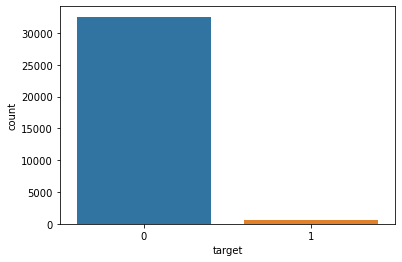

In [8]:
sns.countplot(train['target'])

In [9]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')

CLASSES = [0,1]   

In [10]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        #"class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    #label = tf.cast(example['class'], tf.int32)
    label = tf.cast(example['target'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_TEST_IMAGES))

Dataset: 33126 training images, 10982 unlabeled test images


In [11]:
def build_lrfn(lr_start=0.00001, lr_max=0.0001, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

In [12]:
with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB5(
            input_shape=(*IMAGE_SIZE, 3),
            #weights='imagenet',
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1024, activation = 'relu'), 
        L.Dropout(0.3), 
        L.Dense(512, activation= 'relu'), 
        L.Dropout(0.2), 
        L.Dense(256, activation='relu'), 
        L.Dropout(0.2), 
        L.Dense(128, activation='relu'), 
        L.Dropout(0.1), 
        L.Dense(1, activation='sigmoid')
    ])
    
model.compile(
    optimizer='adam',
    #loss = 'binary_crossentropy',
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.1),
    metrics=['binary_crossentropy']
)
model.summary()


115515392/115515256 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 32, 32, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_______________________________________________________

In [13]:
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [14]:
history = model.fit(
    get_training_dataset(), 
    epochs=EPOCHS, 
    callbacks=[lr_schedule],
    steps_per_epoch=STEPS_PER_EPOCH
    #validation_data=valid_dataset
)

Train for 517 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/12
517/517 [==============================] - 791s 2s/step - loss: 0.2924 - binary_crossentropy: 0.1818

Epoch 00002: LearningRateScheduler reducing learning rate to 4.95e-05.
Epoch 2/12
517/517 [==============================] - 583s 1s/step - loss: 0.2442 - binary_crossentropy: 0.1119

Epoch 00003: LearningRateScheduler reducing learning rate to 8.9e-05.
Epoch 3/12
517/517 [==============================] - 581s 1s/step - loss: 0.2414 - binary_crossentropy: 0.1067

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0001285.
Epoch 4/12
517/517 [==============================] - 582s 1s/step - loss: 0.2404 - binary_crossentropy: 0.1108

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000168.
Epoch 5/12
517/517 [==============================] - 583s 1s/step - loss: 0.2394 - binary_crossentropy: 0.1053

Epoch 00006: LearningRateScheduler reducing learning rate to 0

In [15]:
model.save("efficientnetb5.h5")

In [16]:
#history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS)

In [17]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)

Computing predictions...


In [18]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch

Generating submission.csv file...


In [19]:
pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
pred_df.head()

,image_name,target
0,ISIC_6381819,0.340562
1,ISIC_5583376,0.084019
2,ISIC_6408546,0.070527
3,ISIC_6932354,0.087256
4,ISIC_8191278,0.149346


In [20]:
sub.head()


,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0


In [21]:
del sub['target']
sub = sub.merge(pred_df, on='image_name')
#sub.to_csv('submission_label_smoothing.csv', index=False)
sub.to_csv('submission_b5.csv', index=False)
sub.head()

,image_name,target
0,ISIC_0052060,0.080987
1,ISIC_0052349,0.076095
2,ISIC_0058510,0.074774
3,ISIC_0073313,0.078618
4,ISIC_0073502,0.119621
